In [70]:
# this code can read data and metadata in 384-well format and do the math
# it also asks the user for the name of the data and metadata file names and names the output files accordingly
# this is basically a cleaned up version of v3.0


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os


# get current location and create an output folder
def create_folder():
    current_path = os.getcwd() + "/"
    folder_path = current_path + "output/"
    if not os.path.exists(folder_path):
        output_folder = os.makedirs(folder_path)
        print(f"Folder created at {folder_path}")
    else:
        print(f"Folder already exists at {folder_path}")
    return folder_path


# ask user how the data should be called
def datafiles():
    data_csv = input("Please insert name of data-file (data-file.csv): ") + ".csv"
    metadata_csv = input("Please insert name of metadata-file (data-file.csv): ") + ".csv"
    data_name = data_csv.split(".")
    data_name = data_name[0]
    return data_csv, metadata_csv, data_name

# check if csv is seperated by , or ;
def detect_delimiter(file_path):
    with open(file_path, 'r') as file:
        # Read the first few lines to detect the delimiter
        sample_lines = [file.readline() for _ in range(5)]

    # Check for the presence of common delimiters
    if any(',' in line for line in sample_lines):
        return ','
    elif any(';' in line for line in sample_lines):
        return ';'


# transform data from 384-well format to well, OD format
def prepare_data(data_input):
    # Read the data from a CSV file
    delimiter = detect_delimiter(data_input)
    data = pd.read_csv(data_input, sep=delimiter, index_col=0)
    # Transpose the DataFrame
    data_T = data.T
    # Reset the index and rename the columns
    data_T = data_T.reset_index()
    data_T = data_T.rename(columns={'index': 'well'})
    # Melt the DataFrame to create the desired format
    data_T_melt = pd.melt(data_T, id_vars=['well'], var_name='OD')
    # Combine the 'Well' and 'OD' columns
    data_T_melt['well'] = data_T_melt['OD'] + data_T_melt['well']
    # Keep only the 'Well_OD' and 'value' columns
    data_T_melt = data_T_melt[['well', 'value']]
    # Rename the 'value' column to 'OD'
    data_T_melt = data_T_melt.rename(columns={'value': 'OD'})
    print("quality control of transformed data (data_T_melt): \n")
    print(data_T_melt)
    return data_T_melt, data
    
def prepare_metadata(metadata_input):
    # Read the metadata from a CSV file
    delimiter = detect_delimiter(metadata_input)
    metadata = pd.read_csv(metadata_input, sep=',', index_col=0)
    # Transpose the DataFrame
    metadata_T = metadata.T
    # Reset the index and rename the columns
    meatadata_T = metadata_T.reset_index()
    metadata_T = meatadata_T.rename(columns={'index': 'well'})
    # Melt the DataFrame to create the desired format
    metadata_T_melt = pd.melt(metadata_T, id_vars=['well'], var_name='condition')
    # Combine the 'Well' and 'OD' columns
    metadata_T_melt['well'] = metadata_T_melt['condition'] + metadata_T_melt['well']
    # Keep only the 'Well_OD' and 'value' columns
    metadata_T_melt = metadata_T_melt[['well', 'value']]
    # Rename the 'value' column to 'OD'
    metadata_T_melt = metadata_T_melt.rename(columns={'value': 'condition'})
    print("quality control of transformed metadata (metadata_T_melt): \n")
    print(metadata_T_melt)
    return metadata_T_melt

def merge(data, metadata, folder, data_name): # expects MELTED data and metadata as input
    # merge data and metadata
    merged_data = pd.merge(data, metadata, on = 'well')
    # remove well column
    merged_data = merged_data.drop("well", axis=1)
    merged_data = merged_data.sort_values(by='condition', ascending=False)
    # save merged data file to use it in prism:
    merged_data.to_csv(os.path.join(folder + data_name + '_merged_data.csv'), index=False)
    print("quality control of transformed metadata (metadata_T_melt): \n")
    print("\n saved at: " + os.path.join(folder))
    return merged_data

def group_data(data_merged): # expects merged data as input
    # Group the merged_data DataFrame by 'Condition' and calculate both mean and standard deviation
    # the .agg function calculates both mean and standard deviation
    grouped_data = data_merged.groupby('condition').agg({'OD': ['mean', 'std']})
    # Reset the index to make 'Condition' a column instead of an index
    grouped_data.reset_index(inplace=True)
    # Rename the columns for clarity
    grouped_data.columns = ['condition', 'mean_OD', 'std_OD']
    # Print the resulting DataFrame
    print("quality control of mean and std. (grouped_data): \n")
    print(grouped_data)
    return grouped_data

def plot_BarGraph(data_grouped, folder_path, data_name, fig_size_bar, dpi):
    # Plot the mean values
    plt.bar(data_grouped['condition'], data_grouped['mean_OD'], yerr=data_grouped['std_OD'], capsize=5)
    plt.xlabel('Conditions')
    plt.ylabel('Mean OD Value')
    plt.title('Mean OD Values with Standard Deviation')
    plt.xticks(rotation=90)  # Rotate x-axis labels for readability
    plt.gcf().set_size_inches(fig_size_bar)
    
    # Save the figure
    plt.savefig(os.path.join(folder_path, f'{data_name}_bar-graph.png'), dpi=dpi)

    # Show the plot
    plt.show()

def generate_heatmap(data, folder_path, data_name, fig_size_heat, dpi):
    # Generate Heat Map of data file
    plt.figure(figsize=fig_size_heat)
    sns.heatmap(data, cmap='YlGnBu', annot=True, fmt='.2f', cbar=True, square=False)
    plt.title(data_name + '_Plate Heatmap')

    # Save the figure
    plt.savefig(os.path.join(folder_path, f'{data_name}_heat-map.png'), dpi=dpi)

    # Show the plot
    plt.show()
    
def main():
    # size and resolution of the graphs    
    fig_size_bar = (10, 20) # width, height in inch
    fig_size_heat = (20, 10)
    dpi = 400
    
    folder_path = create_folder()
    data_csv, metadata_csv, data_name = datafiles()
    data_T_melt, data = prepare_data(data_csv)
    metadata_T_melt = prepare_metadata(metadata_csv)
    merged_data = merge(data_T_melt, metadata_T_melt, folder_path, data_name)
    grouped_data = group_data(merged_data)
    plot_BarGraph(grouped_data, folder_path, data_name, fig_size_bar, dpi)
    generate_heatmap(data, folder_path, data_name, fig_size_heat, dpi)


In [71]:
# now calculate a z-score
# the .loc function extracts the value from the table at the crossing point of the descriptors
# the .iloc function lets you do the same, but based on integer row and column positions (e.g. 0, 3)
# df.iloc[row_position, column_position], keep in mind that the df is zero-indexed
# this is still very hard coded and does not work for > 2 conditions...
  #  mean_neg = grouped_data.iloc[1, 1]
  #  mean_pos = grouped_data.iloc[0, 1]
  #  std_neg = grouped_data.iloc[1, 2]
  #  std_pos = grouped_data.iloc[0, 2]
  #  z = 1 - (3*(std_pos+std_neg))/(mean_pos-mean_neg)
  #  print(z)
  #  grouped_data.to_csv(os.path.join(folder_path + data_name + '_statistics_data.csv'), index=False)

Folder already exists at /Users/joschameiers/Desktop/Science & Work/Jupyter Notebooks/384-Plate-plot-single-timepoint/v3.1-test/output/
Please insert name of data-file (data-file.csv): data
Please insert name of metadata-file (data-file.csv): metadata
quality control of transformed data (data_T_melt): 

    well     OD
0     A1  0.988
1     A2  0.985
2     A3  0.902
3     A4  0.956
4     A5  0.968
..   ...    ...
379  P20  0.157
380  P21  0.232
381  P22  0.194
382  P23  0.138
383  P24  0.152

[384 rows x 2 columns]
quality control of transformed metadata (metadata_T_melt): 

    well                 condition
0     A1               300 nL DMSO
1     A2               300 nL DMSO
2     A3               300 nL DMSO
3     A4               300 nL DMSO
4     A5               300 nL DMSO
..   ...                       ...
379  P20  300 nL cipro (133 µg/mL)
380  P21  300 nL cipro (133 µg/mL)
381  P22  300 nL cipro (133 µg/mL)
382  P23  300 nL cipro (133 µg/mL)
383  P24  300 nL cipro (133 µg/mL

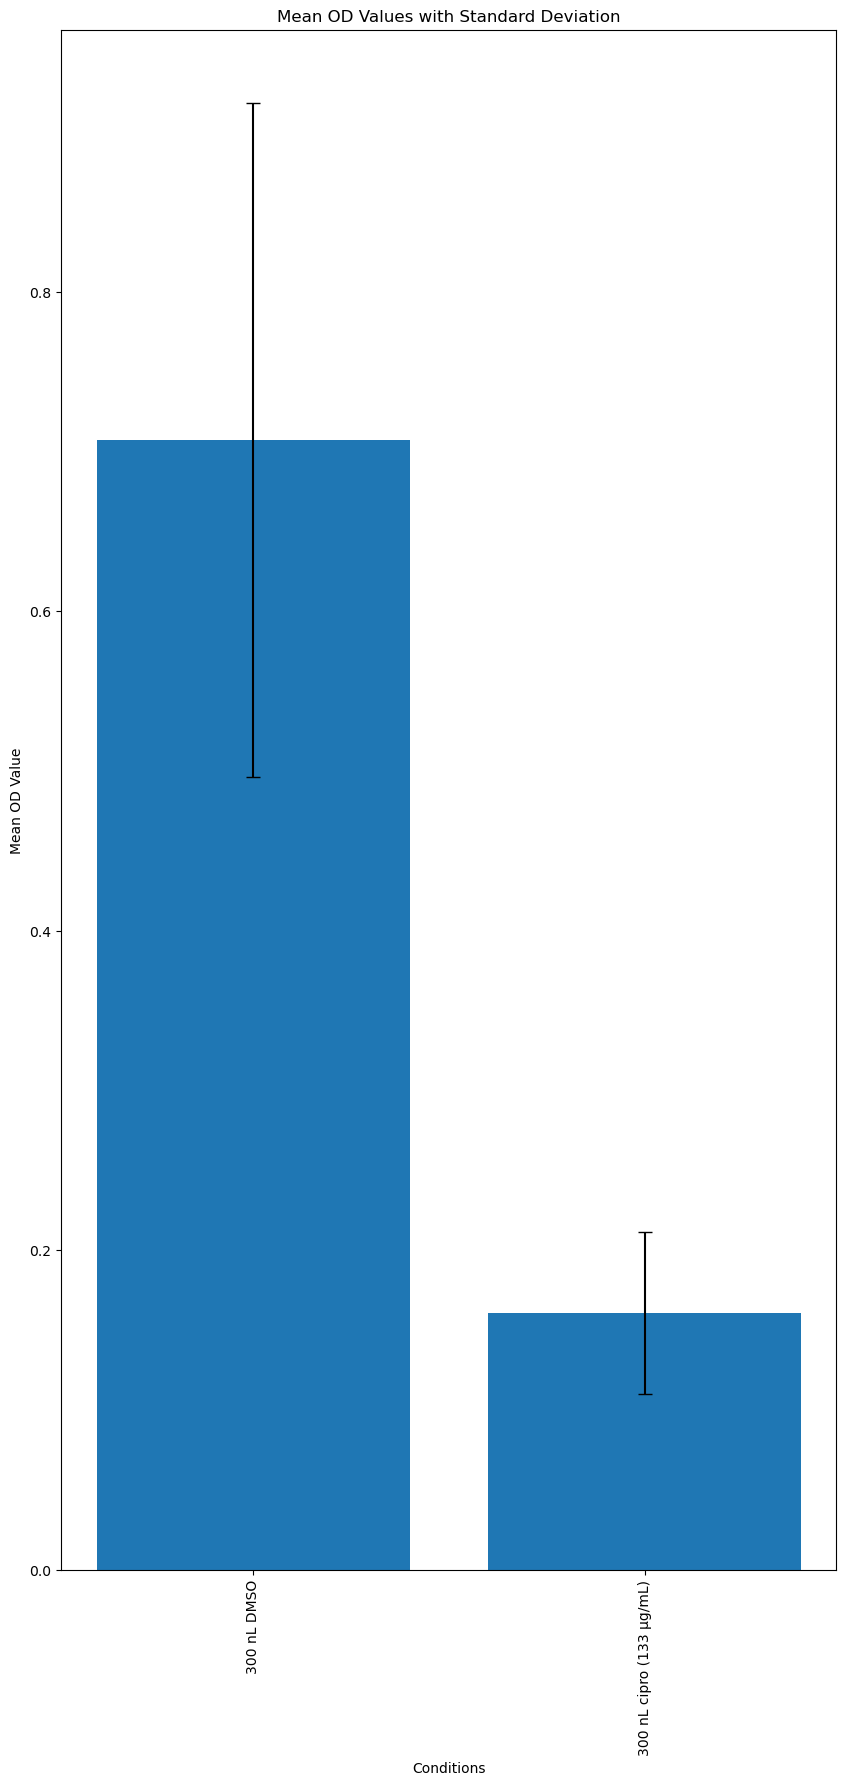

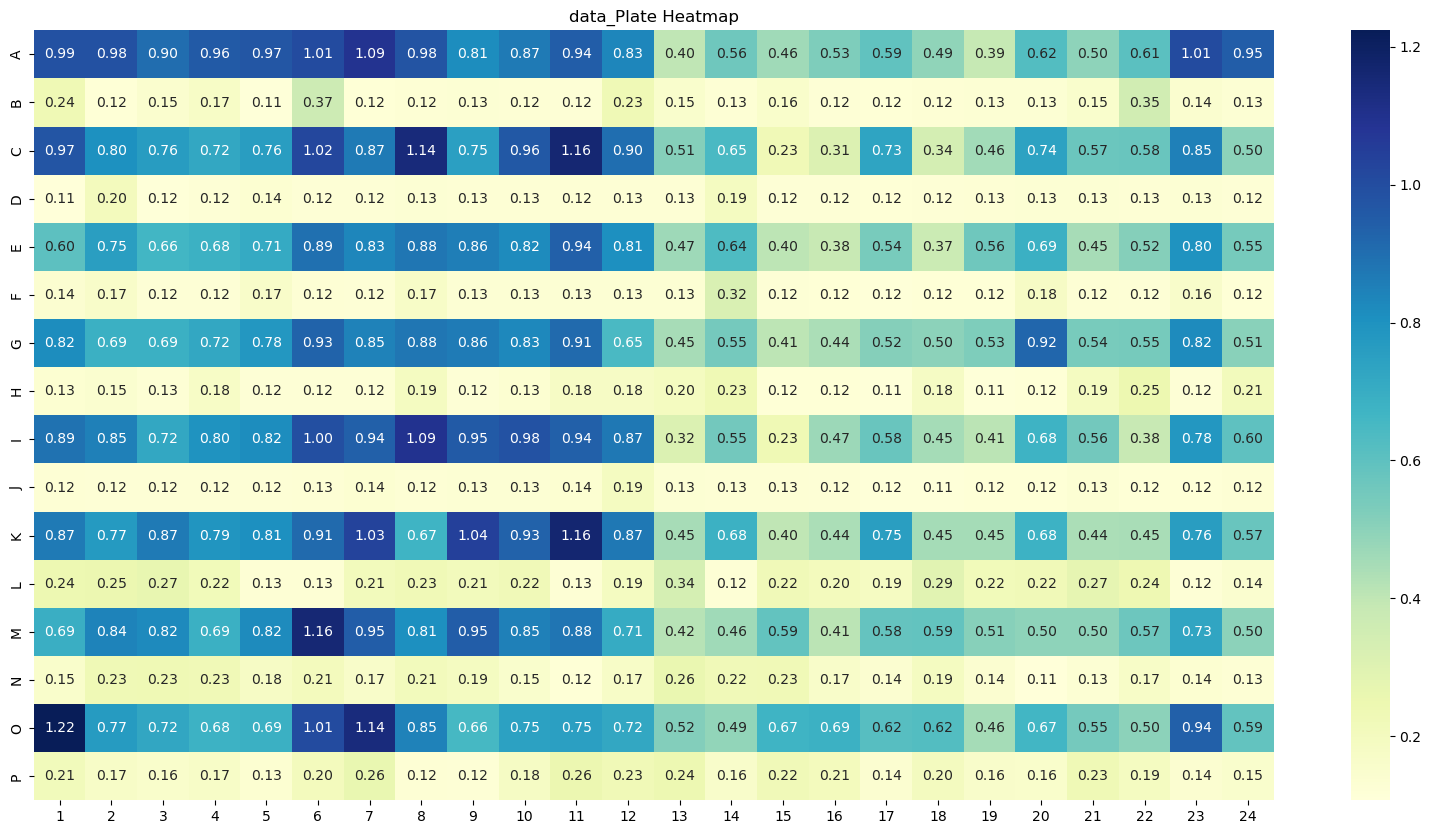

In [72]:
if __name__ == "__main__":
    main()